### 背景

　在当今电子商务与在线交易蓬勃发展的时代，企业面临着日益复杂的市场环境和消费者行为模式。随着交易量的剧增，订单管理成为企业运营的核心环节之一，而订单退单问题直接影响到企业的库存管理、现金流状况以及客户满意度。为了能够解决以上问题，需要对系统中留存的大量历史数据进行分析、标注和建模挖掘，提炼出关键的风险特征指标与消费者行为模式，以提前识别并预测可能引发退单的风险因素，从而帮助企业采取预防措施，优化运营策略，减少经济损失，提升整体服务质量和市场竞争力。

### 数据说明

　**orders.xlsx**数据主要包含**订单编号、用户编号、商品编号、订单金额、支付金额、渠道编号、平台类型、下单时间、支付时间和是否退单**维度，约有**10万余条**数据，产生时间为**2022~2023**年，**Contents.xlsx**数据中包含商品评论文本信息，**约有1万余条**。

**订单数据**

- **数据样例**

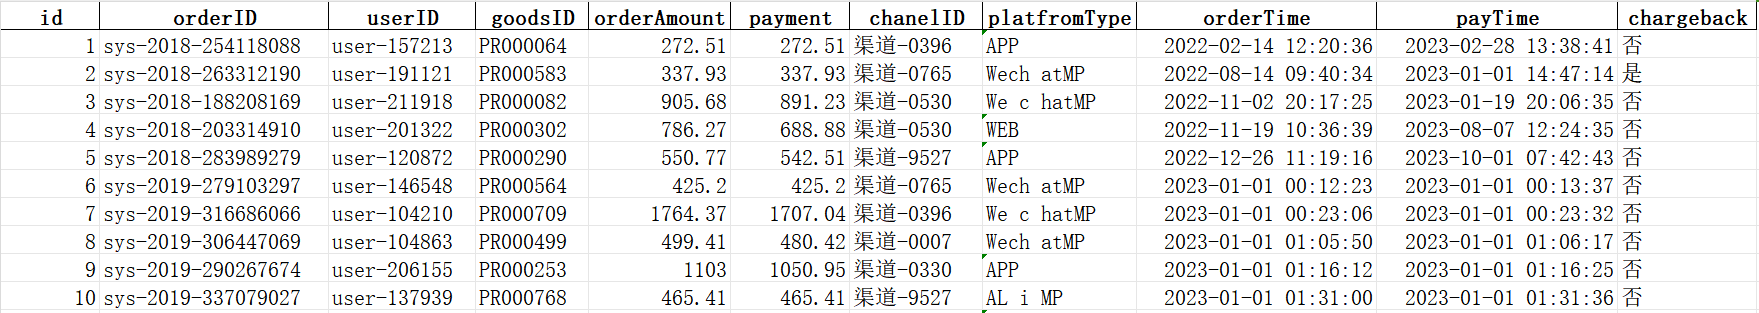

- **字段解读**

| 字段名称     | 字段说明                         |
| ------------ | -------------------------------- |
| id | 编号 |
| orderID | 订单编号 |
| userID | 用户编号 |
| goodsID | 商品编号 |
| orderAmount | 订单金额 |
| payment | 支付金额 |
| chanelID | 渠道编号 |
| platfromType | 平台类型 |
| orderTime | 下单时间 |
| payTime | 支付时间 |
| chargeback | 是否退单 |

**商品评论数据**

- **数据样例**

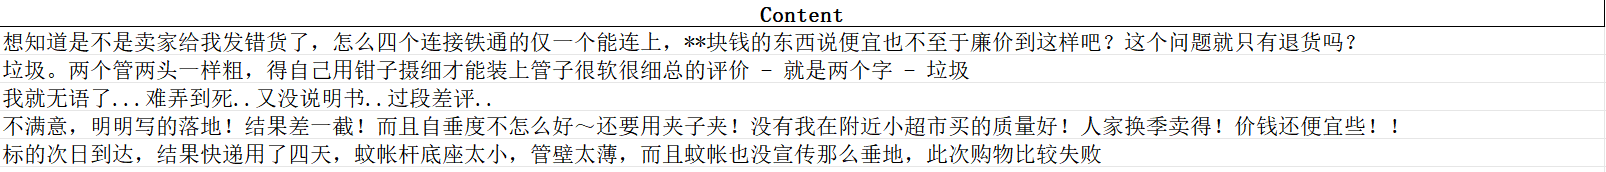

- **字段解读**

| 字段名称     | 字段说明                         |
| ------------ | -------------------------------- |
| Content | 评论文本 |

### 分析思路
#### 1.数据探索
　对订单数据进行概率统计、可视化和相关性分析，理解数据的基本特征和结构，检测数据中的缺失值、异常值和重复值。</br>
#### 2.数据预处理
　对订单数据中的各列进行缺失值、异常值、重复值和一致性处理，保证数据规范性。</br>
#### 3.维度分析
　分析各维度数据，如GMV、订单量占比或分布分析，以从多个角度理解和评估数据，揭示数据背后的信息和关系，支持决策制定。</br>
#### 4.数据标注
　分析用户对商品的评论，提取情感倾向分类，如正面、负面、中性，定义标签体系，丰富用户特征，以便提升客户体验、改进产品和服务。</br>
#### 5.特征处理
　选择重要特征，转化特征与标签的数据类型，拆分数据集，对数据进行标准化，为模型准备输入数据。</br>
#### 6.建模挖掘
　构建随机森林分类模型进行训练挖掘，评估模型，使用网格搜索优化模型的超参数，提升模型拟合效果和效率等。

In [1]:
# 导入数据处理库
import pandas as pd
# 导入numpy库，用于数值计算
import numpy as np
# 导入seaborn库，用于数据可视化
import seaborn as sns
# 导入matplotlib.pyplot模块，用于绘图
import matplotlib.pyplot as plt
# 导入处理中文NLP模型
from snownlp import SnowNLP
# 导入字典编码器
from sklearn.feature_extraction import DictVectorizer
# 导入随机采样模块
from sklearn.utils import resample
# 导入切分数据集、网格搜索模块
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# 导入随机森林分类器模型
from sklearn.ensemble import RandomForestClassifier
# 导入评估模块
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
# 导入标签编码器
from sklearn.preprocessing import LabelEncoder
# 导入warnings库，用于忽略警告信息
import warnings

# 在Jupyter中内联显示图形
%matplotlib inline
# 设置中文显示字体为SimHei
plt.rcParams['font.sans-serif'] = 'SimHei'
# 解决负号'-'等特殊符号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 使用ggplot样式来绘制图形
plt.style.use('ggplot')
# 忽略警告信息，以免干扰代码执行过程
warnings.filterwarnings('ignore')

### 数据探索

1.读取数据</br>
2.查看数据详情与类型</br>
3.重复值检测</br>
4.缺失值检测</br>
5.异常值检测</br>
6.分析特征分布和相关性

<font size=3 color=#0000dd>考点1：使用`pandas`读取“/home/qingjiao/智能订单风险预测/data/”目录下的“orders.xlsx”数据文件，查看数据形状和前 10 行数据。</font>

In [2]:
# 读取订单数据
df = pd.read_excel('/home/qingjiao/智能订单风险预测/data/orders.xlsx')
# 查看数据形状
df.shape
# 查看前 10 行数据
df.head(10)

,id,orderID,userID,goodsID,orderAmount,payment,chanelID,platfromType,orderTime,payTime,chargeback
0,1,sys-2018-254118088,user-157213,PR000064,272.51,272.51,渠道-0396,APP,2022-02-14 12:20:36,2023-02-28 13:38:41,否
1,2,sys-2018-263312190,user-191121,PR000583,337.93,337.93,渠道-0765,Wech atMP,2022-08-14 09:40:34,2023-01-01 14:47:14,是
2,3,sys-2018-188208169,user-211918,PR000082,905.68,891.23,渠道-0530,We c hatMP,2022-11-02 20:17:25,2023-01-19 20:06:35,否
3,4,sys-2018-203314910,user-201322,PR000302,786.27,688.88,渠道-0530,WEB,2022-11-19 10:36:39,2023-08-07 12:24:35,否
4,5,sys-2018-283989279,user-120872,PR000290,550.77,542.51,渠道-9527,APP,2022-12-26 11:19:16,2023-10-01 07:42:43,否
5,6,sys-2019-279103297,user-146548,PR000564,425.20,425.20,渠道-0765,Wech atMP,2023-01-01 00:12:23,2023-01-01 00:13:37,否
6,7,sys-2019-316686066,user-104210,PR000709,1764.37,1707.04,渠道-0396,We c hatMP,2023-01-01 00:23:06,2023-01-01 00:23:32,否
7,8,sys-2019-306447069,user-104863,PR000499,499.41,480.42,渠道-0007,Wech atMP,2023-01-01 01:05:50,2023-01-01 01:06:17,否
8,9,sys-2019-290267674,user-206155,PR000253,1103.00,1050.95,渠道-0330,APP,2023-01-01 01:16:12,2023-01-01 01:16:25,否
9,10,sys-2019-337079027,user-137939,PR000768,465.41,465.41,渠道-9527,AL i MP,2023-01-01 01:31:00,2023-01-01 01:31:36,否


<font size=3 color=#0000dd>考点2：使用`pandas`的一个函数查看数据详情。</font>

In [3]:
# 查看数据详情
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104557 entries, 0 to 104556
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104557 non-null  int64         
 1   orderID       104557 non-null  object        
 2   userID        104557 non-null  object        
 3   goodsID       104557 non-null  object        
 4   orderAmount   104557 non-null  float64       
 5   payment       104557 non-null  float64       
 6   chanelID      104549 non-null  object        
 7   platfromType  104557 non-null  object        
 8   orderTime     104557 non-null  datetime64[ns]
 9   payTime       104557 non-null  datetime64[ns]
 10  chargeback    104557 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 8.8+ MB


<font size=3 color=#0000dd>考点3：使用`pandas`的一个函数统计数值列统计信息，包含最大值、最小值和平均数等。</font>

In [4]:
# 计算各类的统计信息。包含均值、最大值和最小值等。
df.describe()

,id,orderAmount,payment
count,104557.000000,104557.000000,104557.000000
mean,52279.000000,1049.681521,1167.494225
std,30183.150385,1054.409968,2174.024855
min,1.000000,6.100000,-12.470000
25%,26140.000000,432.040000,383.660000
50%,52279.000000,679.320000,641.230000
75%,78418.000000,1248.280000,1252.630000
max,104557.000000,28465.250000,83270.053829


#### 重复值检测

<font size=3 color=#0000dd>考点4：根据订单编号（orderID）检测是否存在重复订单，并输出重复订单的数量。</font>

In [5]:
# 检测数据中的重复记录
duplicate_rows = df[df.duplicated(['orderID'])]
# 打印重复订单数量
print('重复的订单数量：', duplicate_rows['orderID'].count())

重复的订单数量： 27


#### 缺失值检测

<font size=3 color=#0000dd>考点5：检测数据中存在缺失值列，并输出此列和缺失值的数量。</font>

In [6]:
# 统计缺失值
missing_values = df.isnull().sum()
# 判断存在缺失值的列
missing_columns = missing_values[missing_values > 0]
# 输出缺失值列以及缺失值数量
print('存在缺失值的列与数量：', missing_columns)

存在缺失值的列与数量： chanelID    8
dtype: int64


#### 异常值检测

根据电商订单业务的经验，可以将异常值的检测分为以下关注的几点：</br>
　1、订单金额和支付金额小于等于0的数据。</br>
　2、支付金额大于订单金额的数据。</br>
　3、下单时间到支付时间超过“1天”以上的数据（正常下单后的支付时间在“10~30”分钟，为了能保留较多数据样本，设定为1天）。</br>
　4、支付时间小于等于（早于）下单时间的数据。</br>

除以上几点外，还需要关注数据中特殊字符的处理，比如多余空格等。

<font size=3 color=#0000dd>考点6：检测订单金额（orderAmount）和支付金额（payment）小于等于0的异常值，并分别输出异常值的数量（记录数）。</font>

In [7]:
# 检测订单金额和支付金额小于等于0的数据。
count_order_amount = (df['orderAmount'] <= 0).sum()
count_payment = (df['payment'] <= 0).sum()
# 输出订单金额和支付金额小于等于0的异常记录数
print(f'订单金额小于等于0的记录数：{count_order_amount}', f'\n支付金额小于等于0的记录数：{count_payment}')

订单金额小于等于0的记录数：0 
支付金额小于等于0的记录数：182


<font size=3 color=#0000dd>考点7：检测支付金额（payment）大于订单金额（orderAmount）的异常值，并输出异常值的数量（记录数）。</font>

In [8]:
# 检测支付金额大于订单金额的数据。
abnormal_payment_count = (df['payment'] > df['orderAmount']).sum()
# 输出异常支付金额记录数
print(f'支付金额大于订单金额的记录数：{abnormal_payment_count}')

支付金额大于订单金额的记录数：2030


<font size=3 color=#0000dd>考点8：检测下单时间（orderTime）到支付时间（payTime）超过一天的异常值，注意：一天内的订单时间截至为 “**23:59:59**”，并输出异常值的数量（记录数）。</font>

In [9]:
# 检测下单时间到支付时间超过 “1天” 的记录数，（注意：一天内的订单时间截至为 “23:59:59”）。
count_greater_one_day = ((df['payTime'] - df['orderTime']).dt.days >= 1).sum()
# 输出下单时间到支付时间超过“1天”的异常记录数
print(f'下单时间到支付时间超过1天的记录数：{count_greater_one_day}')

下单时间到支付时间超过1天的记录数：217


<font size=3 color=#0000dd>考点9：检测支付时间（payTime）早于或等于下单时间（orderTime）的异常数据（注意：下单到支付的时间不可能同一时刻完成），并输出异常值的数量（记录数）。</font>

In [10]:
# 检测支付时间小于等于（早于）下单时间的数据。
count_abnormal_time = (df['payTime'] <= df['orderTime']).sum()
# 输出支付时间小于下单时间的异常记录数
print(f'支付时间小于下单时间的记录数：{count_abnormal_time}')

支付时间小于下单时间的记录数：132


#### 相关性分析

1、绘制饼状图，观测退单数量的占比。</br>
2、绘制热力图，观察数据特征之间的相关性。</br>

<font size=3 color=#0000dd>考点10：使用`matplotlib`库绘制退单和未退单数量的占比饼图。</font>

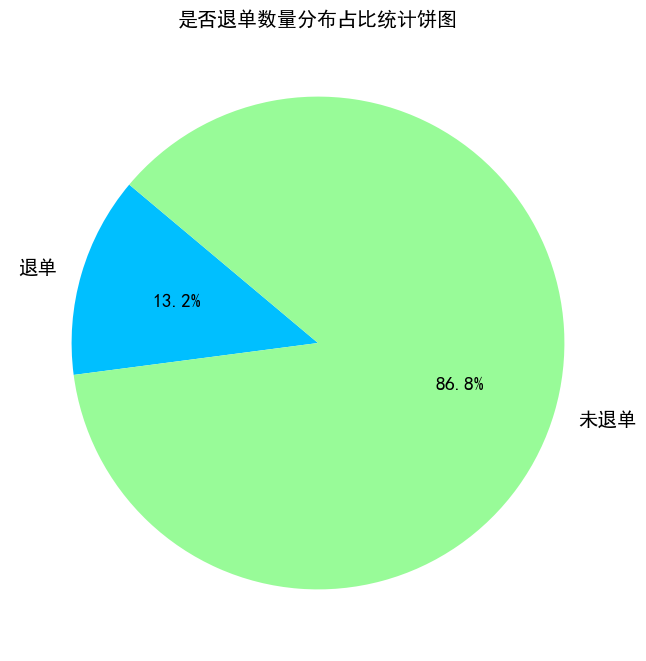

In [11]:
# 统计退单数量和未退单数量
num_chargeback = df[df['chargeback'] == '是'].shape[0] # 统计退单数量
num_nochargeback = df[df['chargeback'] == '否'].shape[0] # 统计未退单数量

# 定义标签和数据
labels = ['退单', '未退单']
values = [num_chargeback, num_nochargeback]

# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, colors=['#00BFFF','#98FB98'], autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=140)
plt.title('是否退单数量分布占比统计饼图')
plt.show()

##### **总结**
　通过饼图的分析信息可以得出，未退单正样本占比总样本的86.8%，而退单负样本占比总样本的13.2%，正负样本的差异较大，后续需要对数据集进行降采样处理，以保障正负样本的合理分布性。

<font size=3 color=#0000dd>考点11：使用`seaborn`库绘制特征之间关联矩阵，查看特征之间的相关性大小。</font>

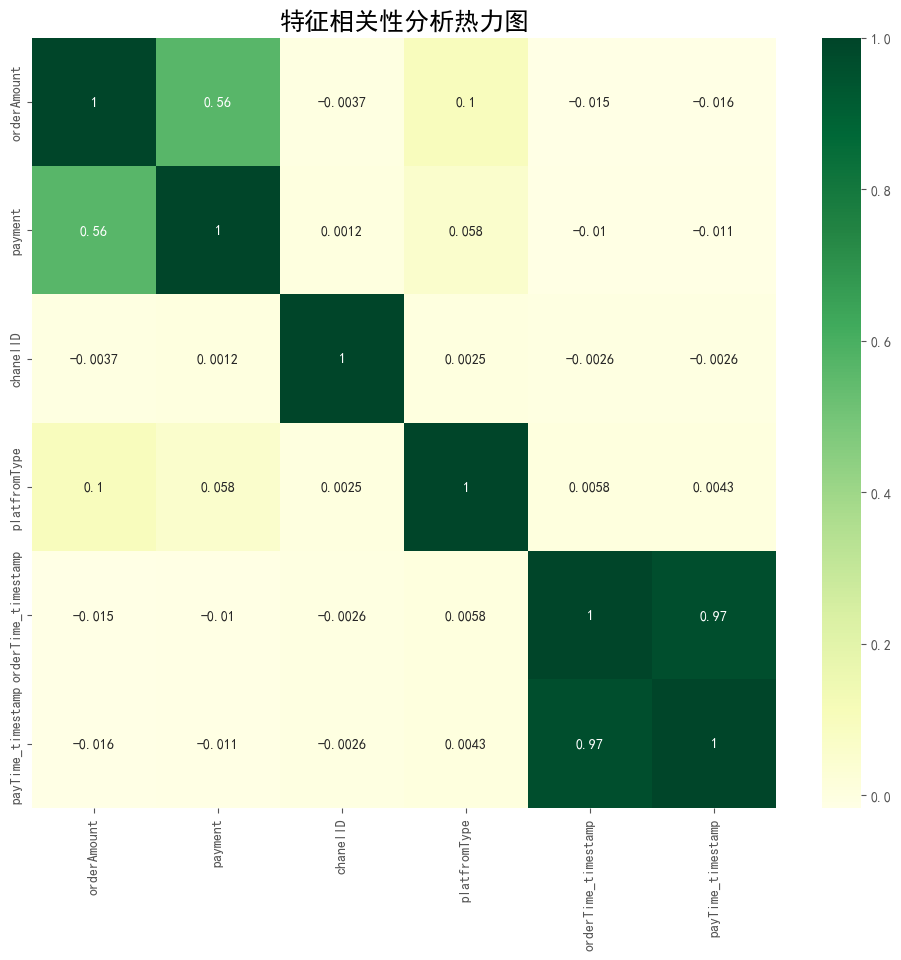

In [12]:
# 选择需要分析的列
cols_to_analyze = ['orderAmount', 'payment', 'chanelID', 'platfromType', 'orderTime', 'payTime']
# 创建子集
df_subset = df[cols_to_analyze].copy()

# 将 orderTime 和 payTime 转换为整数类型的值
df_subset['orderTime_timestamp'] = df_subset['orderTime'].apply(lambda x: int(pd.Timestamp(x).strftime('%Y%m%d%H%M%S')))
df_subset['payTime_timestamp'] = df_subset['payTime'].apply(lambda x: int(pd.Timestamp(x).strftime('%Y%m%d%H%M%S')))
# 删除原日期类型字段
df_subset.drop(['orderTime', 'payTime'], axis=1, inplace=True)

# 创建标签编码器
label_encoder = LabelEncoder()
# 将渠道编号和平台类型特征进行编码，转换为数值类型
df_subset['chanelID'] = label_encoder.fit_transform(df_subset['chanelID'])
df_subset['platfromType'] = label_encoder.fit_transform(df_subset['platfromType'])

# 计算相关矩阵
corr_matrix = df_subset.corr()

# 绘制热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='YlGn')
plt.title('特征相关性分析热力图', fontsize=18)
plt.show()

##### **总结**
　从上述热力图中可以看出，订单金额（orderAmount）和支付金额（payment）具有`0.56`较强的正相关性，渠道编号（chanelID）与其他几个特征的相关性最小，平台类型（platfromType）与订单金额（orderAmount）和支付金额（payment）存在一定的相关性（`0.1`、`0.058`），因业务的限定，下单时间（orderTime）与支付时间（payTime）具有`0.97`的强正相关性。

### 数据预处理

1.删除重复值。</br>
2.填充缺失值。</br>
3.处理异常值。</br>
4.数据一致性处理。

#### 删除重复订单

<font size=3 color=#0000dd>考点12：根据订单编号（orderID）删除重复行，并输出去重前和去重后的数量（总数）。</font>

In [13]:
# 根据“订单编号”删除订单重复值
clean_order_df = df.drop_duplicates(subset='orderID')
# 输出数据去重前后的总数
print(f'去除重复值前的数据总数：{df.shape[0]}', f'\n去除重复值后的数据总数：{clean_order_df.shape[0]}')

去除重复值前的数据总数：104557 
去除重复值后的数据总数：104530


#### 填充渠道缺失值

<font size=3 color=#0000dd>考点13：使用众数填充渠道编号（chanelID）为空的数据行，并统计各列数据，查看是否还存在缺失值。</font>

In [14]:
# 计算渠道编号（chanelID）众数
chanel_mode = clean_order_df['chanelID'].mode()[0]
# 在原 DataFrame 上进行填充缺失值
clean_order_df['chanelID'].fillna(value=chanel_mode, inplace=True)
# 统计各列数据，查看是否还有缺失值
clean_order_df.isnull().sum()

id              0
orderID         0
userID          0
goodsID         0
orderAmount     0
payment         0
chanelID        0
platfromType    0
orderTime       0
payTime         0
chargeback      0
dtype: int64

#### 根据业务过滤异常值

<font size=3 color=#0000dd>考点14：过滤掉下单时间（orderTime）到支付时间（payTime）超过“1天”的异常值，并输出超过1天和1天内的订单数量。</font>

In [15]:
# 因下单时间和支付时间正常不会超过一天，所以要清除支付时间与下单时间异常值。
# 计算时间差
clean_order_df['time_diff'] = clean_order_df['payTime'] - clean_order_df['orderTime']
# 定义时间差，“一天”
one_day = pd.Timedelta(days=1)
# 过滤下单时间到支付时间超过“1天”的异常值数据
filterd_df = clean_order_df[clean_order_df['time_diff'] < one_day]

# 输出超过一天支付和一天内支付的订单数量
print(f"支付时间超过1天的订单数量：{(clean_order_df['time_diff'] > one_day).sum()}", f"\n一天内支付的订单数量：{filterd_df.shape[0]}")

支付时间超过1天的订单数量：217 
一天内支付的订单数量：104313


<font size=3 color=#0000dd>考点15：过滤掉支付时间（payTime）早于（小于）下单时间（orderTime）的异常值，注意下单到支付之间不会同一时刻完成，并输出过滤异常值前后的数量。</font>

In [16]:
# 过滤支付时间小于或等于下单时间的异常值记录。
clean_time_df = filterd_df[filterd_df['payTime'] > filterd_df['orderTime']]
# 输出异常数据总数和过滤后总数
print(f"支付时间小于下单时间的数量：{(filterd_df['payTime'] <= filterd_df['orderTime']).sum()}", f"\n支付时间大于下单时间的数量：{clean_time_df.shape[0]}")

支付时间小于下单时间的数量：132 
支付时间大于下单时间的数量：104181


<font size=3 color=#0000dd>考点16：过滤掉订单金额（orderAmount）和支付金额（payment）小于等于0的异常值，并输出过滤异常值前后的数量。</font>

In [17]:
# 过滤订单金额和支付金额小于等于 0 的记录
clean_amount_df = clean_time_df[clean_time_df['orderAmount'] > 0]
clean_payment_df = clean_amount_df[clean_amount_df['payment'] > 0]
# 输出异常数据总数和过滤后的总数
print(f"订单金额和支付金额小于等于0的数量：{(clean_time_df['orderAmount'] <= 0).sum(), (clean_amount_df['payment'] <= 0).sum()}", 
      f"订单金额和支付金额大于0的数量：{clean_amount_df.shape[0], clean_payment_df.shape[0]}")

订单金额和支付金额小于等于0的数量：(0, 177) 订单金额和支付金额大于0的数量：(104181, 104004)


<font size=3 color=#0000dd>考点17：过滤掉支付金额（payment）大于订单金额（orderAmount）的异常值，并输出过滤异常值前后的数量。</font>

In [18]:
# 过滤“支付金额”大于“订单金额”的数据
clean_price_df = clean_payment_df[clean_payment_df['payment'] <= clean_payment_df['orderAmount']]
# 输出异常数据总数和过滤后的总数
print(f"支付金额大于订单金额的数量：{(clean_payment_df['payment'] > clean_payment_df['orderAmount']).sum()}", f"\n支付金额小于等于订单金额的数量：{clean_price_df.shape[0]}")

支付金额大于订单金额的数量：2022 
支付金额小于等于订单金额的数量：101982


#### 数据一致性处理

<font size=3 color=#0000dd>考点18：处理平台类型（platfromType）字段值中存在的多余空格字符，并查看前 10 行数据。</font>

In [19]:
# 特殊字段处理，“平台类型（platfromType）”字段中出现了多余空格的值，为保证数据一致性，需要将多余空格进行剔除。
clean_price_df['platfromType'] = clean_price_df['platfromType'].str.replace(' ','')
# 查看去除空格后的前 10 行数据
clean_price_df.head(10)

,id,orderID,userID,goodsID,orderAmount,payment,chanelID,platfromType,orderTime,payTime,chargeback,time_diff
5,6,sys-2019-279103297,user-146548,PR000564,425.20,425.20,渠道-0765,WechatMP,2023-01-01 00:12:23,2023-01-01 00:13:37,否,0 days 00:01:14
6,7,sys-2019-316686066,user-104210,PR000709,1764.37,1707.04,渠道-0396,WechatMP,2023-01-01 00:23:06,2023-01-01 00:23:32,否,0 days 00:00:26
7,8,sys-2019-306447069,user-104863,PR000499,499.41,480.42,渠道-0007,WechatMP,2023-01-01 01:05:50,2023-01-01 01:06:17,否,0 days 00:00:27
8,9,sys-2019-290267674,user-206155,PR000253,1103.00,1050.95,渠道-0330,APP,2023-01-01 01:16:12,2023-01-01 01:16:25,否,0 days 00:00:13
9,10,sys-2019-337079027,user-137939,PR000768,465.41,465.41,渠道-9527,ALiMP,2023-01-01 01:31:00,2023-01-01 01:31:36,否,0 days 00:00:36
10,11,sys-2019-417411381,user-181957,PR000483,279.53,279.53,渠道-0007,APP,2023-01-01 01:36:17,2023-01-01 01:36:56,否,0 days 00:00:39
11,12,sys-2019-254286596,user-174586,PR000322,622.70,622.70,渠道-0283,WechatMP,2023-01-01 01:37:00,2023-01-01 01:37:14,否,0 days 00:00:14
12,13,sys-2019-303647260,user-178023,PR000685,969.61,913.58,渠道-0765,APP,2023-01-01 02:11:23,2023-01-01 02:12:56,否,0 days 00:01:33
13,14,sys-2019-347419495,user-209896,PR000483,279.18,225.15,渠道-0396,APP,2023-01-01 02:31:13,2023-01-01 02:32:40,否,0 days 00:01:27
14,15,sys-2019-384544993,user-148994,PR000004,3424.78,3424.78,渠道-0530,WechatMP,2023-01-01 02:57:16,2023-01-01 02:57:42,否,0 days 00:00:26


### 维度分析

1.GMV（Gross Merchandise Volume，商品交易总额）趋势分析，关注近一年内每个月的商品销售总金额的变化。</br>
2.各平台订单量占比分析，查看不同销售平台中的订单数量占总订单量的比例。</br>
3.一周内订单量分析，关注每天的销售情况。</br>
4.单日内订单量分析，查看一天内每个时段销售情况，寻找峰值时段，调整营销策略。

<font size=3 color=#0000dd>考点19：统计每月GMV，并使用`matplotlib`绘制一年（12个月）的 “GMV趋势变化折线图”。</font>

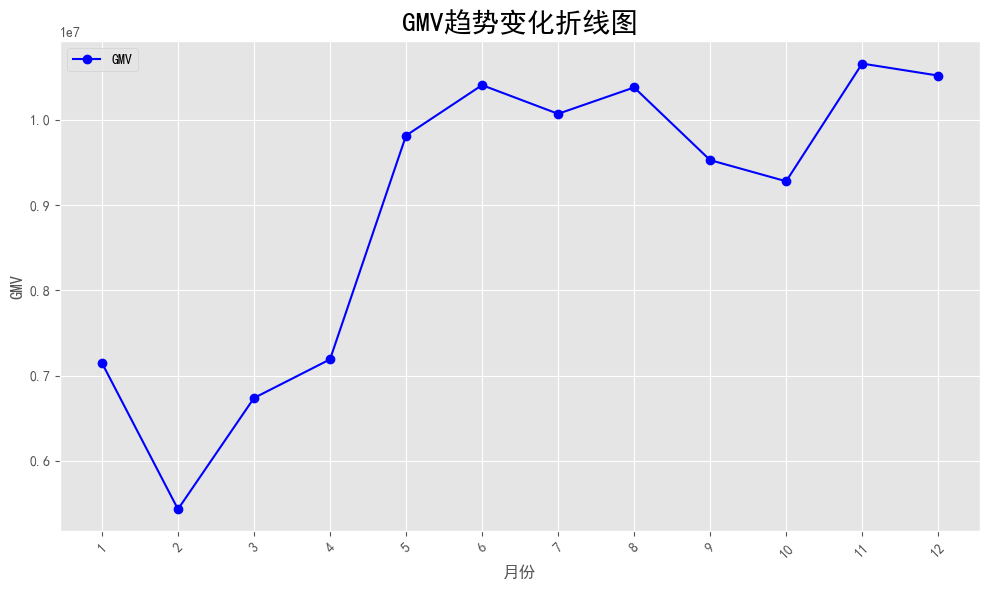

In [20]:
# 获取每笔订单月份
clean_price_df['orderTimeMonth'] = clean_price_df['orderTime'].dt.month
# 根据月份分组，计算每月的GMV。
month_gmv = clean_price_df.groupby(by='orderTimeMonth')['orderAmount'].sum()

# 提取月份和 GMV 数据
months = month_gmv.index.tolist()
gmv_values = month_gmv.values.tolist()

# 设置画布大小
plt.figure(figsize=(10, 6))
# 绘制折线图
plt.plot(months, gmv_values, marker='o', linestyle='-', color='b', label='GMV')
plt.xlabel('月份') # 设置 X 轴标签
plt.ylabel('GMV') # 设置 Y 轴标签
plt.title('GMV趋势变化折线图', fontsize=20) # 设置标题
plt.xticks(months, rotation=45)  # 显示全部月份刻度
plt.grid(True) # 启用网格线
plt.legend() # 显示图例
plt.tight_layout()  # 自动调整布局，防止标签被切断
plt.show() # 显示图形

##### **结果解读**
　通过折线图可以看到第一季度时交易额较低，反应公司在第一季度并没有太多盈利，然后从5月份交易额开始飙升，这其中原因可能是公司调整了营销策略而导致的，10月份有所下滑，但是11月又有所上升，整体来看公司整年营收效益比较好。

<font size=3 color=#0000dd>考点20：分组统计各平台订单量，并使用`matplotlib`绘制 “各平台订单量占比饼图”。</font>

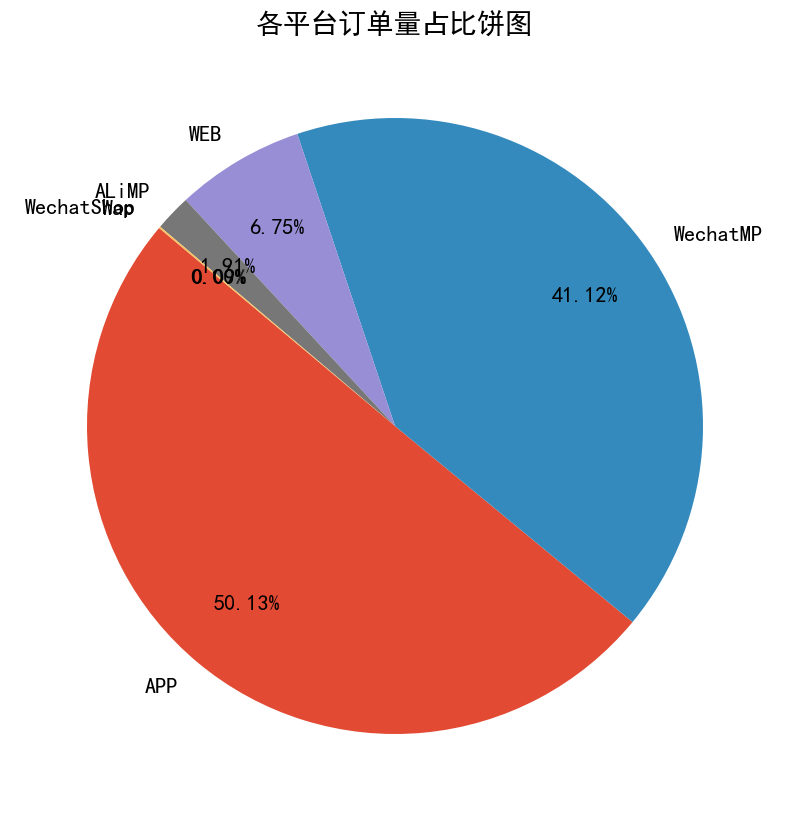

In [21]:
# 统计每个平台的订单量
platform_count = clean_price_df.groupby(by='platfromType')['id'].count().sort_values(ascending=False)

# 提取平台和各平台订单数量
platform = platform_count.index.tolist()
counts = platform_count.values.tolist()

# 设置画布大小
plt.figure(figsize=(16, 10))  # 设置图形大小
# 绘制饼图
plt.pie(counts, labels=platform, autopct='%.2f%%', pctdistance=0.75, labeldistance=1.1, textprops={'fontsize': 16}, startangle=140)
# 添加标题
plt.title('各平台订单量占比饼图', fontsize=20)
# 显示图形
plt.show()

##### **结果解读**
　通过饼图中可以看到，从APP平台销售的订单最多，占总量的50.13%，其次是从WechatMP平台进行下单的用户群体，占总量的41.12%，最后是从WEB端进行下单购买的用户，占总量的6.75%，而其余两个平台占比较少，后续可针对前三个平台施行不同的营销策略，加大营收效益。